In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import tqdm
import json
import torch
import warnings
import numpy as np
import torch.nn as nn
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
from chnet.torchsummary import summary
from torchvision import transforms, utils
from toolz.curried import pipe, curry, compose
from torch.utils.data import Dataset, DataLoader

In [3]:
import utilities as utils
import chnet.cahn_hill as ch
import chnet.ch_tools as tools

you can install PyFFTW for speed-up as - 
conda install -c conda-forge pyfftw


In [4]:
from chnet.unet import UNet
from chnet.ch_net import CHnet
from chnet.ch_loader import CahnHillDataset

In [5]:
warnings.filterwarnings('ignore')

In [6]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=5)

In [7]:
def init_unif(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    return np.random.uniform(-0.95, 0.95, size=(nsamples, dim_x, dim_y))


def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.1, 0.1, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.1, 0.5, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.95, 0.95, out=x_data)
    
    return x_data

## Loss Functions

In [8]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return ((y1 - y2) ** 2).sum() / y1.data.nelement() * scale

@curry
def rmse_loss(y1, y2, scale=1.):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()) * scale


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    return np.sum(((y1 - y2) ** 2)) / y1.size

## Transformers

In [9]:
@curry
def add_neighbors(x):
    dimx = x.shape[0]
    y = np.pad(x, pad_width=[[2,2],[2,2]], mode="wrap")
    out = [x[None]]
    for ix in [0, 1, 2, 3, 4]:
        for iy in [0, 1, 2, 3, 4]:
            out.append((y[ix:ix+dimx, iy:iy+dimx] * x)[None])
    return np.concatenate(out, axis=0)

## Data Generators

In [10]:
@curry
def data_generator(nsamples=128, 
                   dim_x=64, 
                   init_steps=100, 
                   delta_sim_steps = 500,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   seed = None,
                   device = torch.device("cuda:0")):
    
    init_data1 = init_unif(nsamples//2, dim_x, dim_x, seed=seed)
    init_data2 = init_norm(nsamples//2, dim_x, dim_x, seed=seed)
    init_data = np.concatenate([init_data1, init_data2], axis=0)
    
    x_data = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, device=device)
    y_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps+delta_sim_steps, device=device)
    return x_data, y_data

In [11]:
x_data, y_data = data_generator(nsamples=16, dim_x=64, 
                                init_steps=10, 
                                delta_sim_steps = 50,
                                dx = 0.25, 
                                dt = 0.01,
                                gamma=1.0, 
                                seed = None,
                                device = torch.device("cuda:0"))

# Set Device

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN Model

In [14]:
from chnet.unet import UNet
model = UNet(in_channels=1, 
             out_channels=1, 
             init_features=32).to(device)
summary(model, input_size=(1, 64, 64))

# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
#                        in_channels=1, 
#                        out_channels=1, 
#                        init_features=32, 
#                        pretrained=False).double().to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             288
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,216
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
         MaxPool2d-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          18,432
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

(tensor(7762465), tensor(7762465))

In [15]:
transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]

dataset = CahnHillDataset(x_data, y_data, transform_x=transformer_x, transform_y=transformer_y)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)

print(x.shape, y.shape)

torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])


In [16]:
model = UNet(in_channels=1, 
             out_channels=1, 
             init_features=32).double().to(device)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)
y_pred = model(x)

assert y.shape == y_pred.shape
print(mse_loss(y, y_pred).data)

tensor(0.1014, device='cuda:0', dtype=torch.float64)


# Model Training

### Training and Validation data generation

In [55]:
## Process Parameters
dim_x=64
init_steps=10
delta_sim_steps = 2000
dx = 0.25 
dt = 0.01
gamma=1.0

seed_trn = 110364
seed_val = 986423
seed_prd = 284296

n_samples_trn = 1024*1
n_samples_val = 128
n_samples_prd = 32

init_features=32

In [56]:
args = {}
args["dim_x"] = dim_x
args["init_steps"] = init_steps
args["delta_sim_steps"] = delta_sim_steps
args["dx"] = dx
args["dt"] = dt
args["gamma"] = gamma
args["seed_trn"] = seed_trn
args["seed_val"] = seed_val
args["seed_val"] = seed_prd

args["n_samples_trn"] = n_samples_trn
args["n_samples_val"] = n_samples_val
args["n_samples_prd"] = n_samples_prd

args["init_features"] = init_features

In [57]:
%%time
x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_trn,
                                device = device)



x_val, y_val = data_generator(nsamples=n_samples_val, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_val,
                                device = device)

x_prd, y_prd = data_generator(nsamples=n_samples_prd, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_prd,
                                device = device)

CPU times: user 4.06 s, sys: 2.76 s, total: 6.83 s
Wall time: 6.83 s


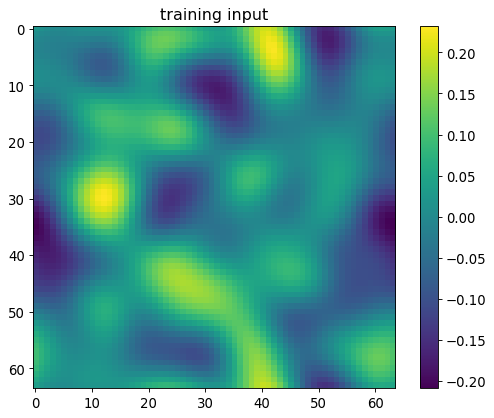

In [58]:
draw_im(x_trn[0], "training input")

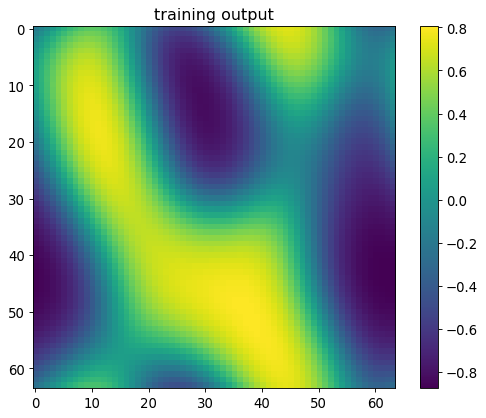

In [59]:
draw_im(y_trn[0], "training output")

In [66]:
transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]

trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
prd_dataset = CahnHillDataset(x_prd, y_prd, transform_x=transformer_x, transform_y=transformer_y)

batch_size = 4

trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
prd_loader = DataLoader(prd_dataset, batch_size=8, shuffle=True, num_workers=1)


total_step = len(trn_loader)
print("No. of training steps: %d" % total_step)
total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)
total_val_step = len(prd_loader)
print("No. of prediction steps: %d" % total_val_step)

No. of training steps: 256
No. of validation steps: 32
No. of prediction steps: 4


In [67]:
dt_string = datetime.now().strftime("%d-%m-%Y-%H-%M")

In [68]:
run = 10
run_id = dt_string + "_run_" +str(run)
print(run_id)

folder = "out/unet/ch_unet_id_{}/".format(run_id)
print(folder)

if not os.path.exists(folder):
    os.makedirs(folder)
    
with open(folder+'params.json', 'w') as fp:
    json.dump(args, fp)
    
tag = folder+"unet_"
print(tag)

10-04-2020-21-22_run_10
out/unet/ch_unet_id_10-04-2020-21-22_run_10/
out/unet/ch_unet_id_10-04-2020-21-22_run_10/unet_


In [63]:
from chnet.unet import UNet
model = UNet(in_channels=1, 
             out_channels=1, 
             init_features=init_features).double().to(device)

In [69]:
num_epochs = 20
criterion = mse_loss(scale=10000)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
trn_losses = []
val_losses = []

In [77]:
# Loss and optimizer
for epoch in range(num_epochs):    
    torch.save(model.state_dict(), tag+"epoch_{}.pt".format(epoch))              
    for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):
        
        
        model.train()
        
        x = item_trn['x'].to(device)
        y_tru = item_trn['y'].to(device)

        # Forward pass
        y_prd = model(x)
        loss = criterion(y_tru, y_prd)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trn_losses.append(np.sqrt(loss.item()))
        
        if (i) % 64 == 0:
            for item_val in val_loader:
                model.eval()
                x1 = item_trn['x'].to(device)
                y1 = item_trn['y'].to(device)
                # Forward pass
                y2 = model(x1)
                val_losses.append(np.sqrt(criterion(y2, y1).item()))
                    
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}, Validation Loss: {:.11f}'.format(epoch+1, 
                                                                                                          num_epochs, 
                                                                                                          i+1, 
                                                                                                          total_step, 
                                                                                                          np.mean(trn_losses[-16:]), 
                                                                                                          np.mean(val_losses[-total_val_step:])))
            
# torch.save(model.state_dict(), tag+"epoch_{}.pt".format(num_epochs)) 

Epoch [1/20], Step [1/256], Training Loss: 8.70864186006, Validation Loss: 7.62187661418
Epoch [1/20], Step [65/256], Training Loss: 9.33055298165, Validation Loss: 8.71996937337
Epoch [1/20], Step [129/256], Training Loss: 8.69054080360, Validation Loss: 8.66375501487
Epoch [1/20], Step [193/256], Training Loss: 8.72198204723, Validation Loss: 7.28778867476



Epoch [2/20], Step [1/256], Training Loss: 8.83609361325, Validation Loss: 6.49654122392
Epoch [2/20], Step [65/256], Training Loss: 8.07930781073, Validation Loss: 8.13848802366
Epoch [2/20], Step [129/256], Training Loss: 8.26459173620, Validation Loss: 11.81026772376
Epoch [2/20], Step [193/256], Training Loss: 8.39845670910, Validation Loss: 6.99937640959



Epoch [3/20], Step [1/256], Training Loss: 8.31619715257, Validation Loss: 7.99099346972
Epoch [3/20], Step [65/256], Training Loss: 7.83011449021, Validation Loss: 7.43343265284
Epoch [3/20], Step [129/256], Training Loss: 9.20924934981, Validation Loss: 10.87508170168
Epoch [3/20], Step [193/256], Training Loss: 8.32212971764, Validation Loss: 7.21154051862



Epoch [4/20], Step [1/256], Training Loss: 8.02573082520, Validation Loss: 7.60603148465
Epoch [4/20], Step [65/256], Training Loss: 8.39623909479, Validation Loss: 8.53563496757
Epoch [4/20], Step [129/256], Training Loss: 7.79471579629, Validation Loss: 8.31849034767
Epoch [4/20], Step [193/256], Training Loss: 8.07584753076, Validation Loss: 6.33552693012



Epoch [5/20], Step [1/256], Training Loss: 7.99914544050, Validation Loss: 6.70354541573
Epoch [5/20], Step [65/256], Training Loss: 7.73934865303, Validation Loss: 7.54685424954
Epoch [5/20], Step [129/256], Training Loss: 7.49391395479, Validation Loss: 8.87249189664
Epoch [5/20], Step [193/256], Training Loss: 7.90009875981, Validation Loss: 9.51727282721



Epoch [6/20], Step [1/256], Training Loss: 7.93561999617, Validation Loss: 5.99123119094
Epoch [6/20], Step [65/256], Training Loss: 7.51349515836, Validation Loss: 7.97735314445
Epoch [6/20], Step [129/256], Training Loss: 7.59674950047, Validation Loss: 6.40134736835
Epoch [6/20], Step [193/256], Training Loss: 7.86539133739, Validation Loss: 7.50087354499



Epoch [7/20], Step [1/256], Training Loss: 7.90080045748, Validation Loss: 7.12030403982
Epoch [7/20], Step [65/256], Training Loss: 7.36731149083, Validation Loss: 6.90973910745
Epoch [7/20], Step [129/256], Training Loss: 7.93393616711, Validation Loss: 6.11308798313
Epoch [7/20], Step [193/256], Training Loss: 7.65607985038, Validation Loss: 6.85289594145



Epoch [8/20], Step [1/256], Training Loss: 7.67119201776, Validation Loss: 5.90072013653
Epoch [8/20], Step [65/256], Training Loss: 7.39647915314, Validation Loss: 6.06968367803
Epoch [8/20], Step [129/256], Training Loss: 6.87048786817, Validation Loss: 6.24897599594
Epoch [8/20], Step [193/256], Training Loss: 7.33171351133, Validation Loss: 5.81632222567



Epoch [9/20], Step [1/256], Training Loss: 7.43443592648, Validation Loss: 5.80486513850
Epoch [9/20], Step [65/256], Training Loss: 7.38131276040, Validation Loss: 6.84544545279
Epoch [9/20], Step [129/256], Training Loss: 7.27206029497, Validation Loss: 5.80755693698
Epoch [9/20], Step [193/256], Training Loss: 6.83385950475, Validation Loss: 6.91841341075



Epoch [10/20], Step [1/256], Training Loss: 7.56036666979, Validation Loss: 6.42010550368
Epoch [10/20], Step [65/256], Training Loss: 7.63353759691, Validation Loss: 8.20195712244
Epoch [10/20], Step [129/256], Training Loss: 7.20817169591, Validation Loss: 6.12193260598
Epoch [10/20], Step [193/256], Training Loss: 7.05500045282, Validation Loss: 5.63643698280



Epoch [11/20], Step [1/256], Training Loss: 6.81991769188, Validation Loss: 7.86173499525
Epoch [11/20], Step [65/256], Training Loss: 7.48634961156, Validation Loss: 6.38284824589
Epoch [11/20], Step [129/256], Training Loss: 7.24088697747, Validation Loss: 5.94112405244
Epoch [11/20], Step [193/256], Training Loss: 7.27973114859, Validation Loss: 5.86257113456



Epoch [12/20], Step [1/256], Training Loss: 6.45221097338, Validation Loss: 5.31448005033
Epoch [12/20], Step [65/256], Training Loss: 6.62786362838, Validation Loss: 5.14876955218
Epoch [12/20], Step [129/256], Training Loss: 6.93873745138, Validation Loss: 5.44748699532
Epoch [12/20], Step [193/256], Training Loss: 7.00925788645, Validation Loss: 7.33477905629



Epoch [13/20], Step [1/256], Training Loss: 7.33393998536, Validation Loss: 6.07758242444
Epoch [13/20], Step [65/256], Training Loss: 6.86727942480, Validation Loss: 8.54812005461
Epoch [13/20], Step [129/256], Training Loss: 7.14994729482, Validation Loss: 5.77253730696
Epoch [13/20], Step [193/256], Training Loss: 7.39126796459, Validation Loss: 6.90116292616



Epoch [14/20], Step [1/256], Training Loss: 6.99646859975, Validation Loss: 6.17337853543
Epoch [14/20], Step [65/256], Training Loss: 6.99402302955, Validation Loss: 5.37612740629
Epoch [14/20], Step [129/256], Training Loss: 6.59234856284, Validation Loss: 5.94927402124
Epoch [14/20], Step [193/256], Training Loss: 6.95999646656, Validation Loss: 6.25698463930



Epoch [15/20], Step [1/256], Training Loss: 7.01067983764, Validation Loss: 6.50136820562
Epoch [15/20], Step [65/256], Training Loss: 6.60533487031, Validation Loss: 5.04408562238
Epoch [15/20], Step [129/256], Training Loss: 6.79622019692, Validation Loss: 4.90172922435
Epoch [15/20], Step [193/256], Training Loss: 6.51905316619, Validation Loss: 5.27578196587



Epoch [16/20], Step [1/256], Training Loss: 6.51802498480, Validation Loss: 5.63519068602
Epoch [16/20], Step [65/256], Training Loss: 7.19149385365, Validation Loss: 5.62903053796
Epoch [16/20], Step [129/256], Training Loss: 6.23642662675, Validation Loss: 5.42874806474
Epoch [16/20], Step [193/256], Training Loss: 6.67141873882, Validation Loss: 5.87300414441



Epoch [17/20], Step [1/256], Training Loss: 6.26101498619, Validation Loss: 8.68118426212
Epoch [17/20], Step [65/256], Training Loss: 6.77658487586, Validation Loss: 4.85163649977
Epoch [17/20], Step [129/256], Training Loss: 6.57841451417, Validation Loss: 6.05443553077
Epoch [17/20], Step [193/256], Training Loss: 6.13558124153, Validation Loss: 4.85111992955



Epoch [18/20], Step [1/256], Training Loss: 6.40078397009, Validation Loss: 5.48383667738
Epoch [18/20], Step [65/256], Training Loss: 5.87582369664, Validation Loss: 4.78589295656
Epoch [18/20], Step [129/256], Training Loss: 6.17136208201, Validation Loss: 4.84488065843
Epoch [18/20], Step [193/256], Training Loss: 6.15402817115, Validation Loss: 4.62941852369



Epoch [19/20], Step [1/256], Training Loss: 6.84854887075, Validation Loss: 5.44733858860
Epoch [19/20], Step [65/256], Training Loss: 6.16803203382, Validation Loss: 5.14592950534
Epoch [19/20], Step [129/256], Training Loss: 6.13823113776, Validation Loss: 5.84045685645
Epoch [19/20], Step [193/256], Training Loss: 6.53091309219, Validation Loss: 6.83048336841



Epoch [20/20], Step [1/256], Training Loss: 6.93505212304, Validation Loss: 5.94788751853
Epoch [20/20], Step [65/256], Training Loss: 6.23806330940, Validation Loss: 6.67036045225
Epoch [20/20], Step [129/256], Training Loss: 6.32080662611, Validation Loss: 5.18333856355
Epoch [20/20], Step [193/256], Training Loss: 6.34086500234, Validation Loss: 6.17928027910



In [71]:
torch.save(model.state_dict(), tag+"epoch_{}.pt".format(num_epochs)) 

In [79]:
prd_losses = []
for item_prd in trn_loader:
    model.eval()
    x1 = item_prd['x'].to(device)
    y1 = item_prd['y'].to(device)
    # Forward pass
    y2 = model(x1)
    prd_losses.append(np.sqrt(criterion(y2, y1).item()))
print(np.mean(prd_losses), np.std(prd_losses))

6.293469993582779 1.0629369243083167


In [78]:
prd_losses = []
for item_prd in prd_loader:
    model.eval()
    x1 = item_prd['x'].to(device)
    y1 = item_prd['y'].to(device)
    # Forward pass
    y2 = model(x1)
    prd_losses.append(np.sqrt(criterion(y2, y1).item()))
print(np.mean(prd_losses), np.std(prd_losses))

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/nv/hp22/ashanker9/data/anaconda/envs/chnet/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/nv/hp22/ashanker9/data/anaconda/envs/chnet/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/nv/hp22/ashanker9/data/anaconda/envs/chnet/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/gpfs/scratch1/5/ashanker9/chnet/chnet/ch_loader.py", line 22, in __getitem__
    im_y = self.arr_y[idx]
RuntimeError: CUDA error: initialization error


In [80]:
print(prd_losses)

[5.38945794463389, 4.9809763109312115, 5.224537721771223, 6.196230181224757, 5.432844683781023, 6.186691780495627, 4.891283136292583, 7.358174897231126, 7.4319004068485235, 5.503171357653155, 5.067860442680096, 7.626452983442647, 5.200646656488143, 5.538280370956148, 5.837237587747024, 5.75509979555241, 5.630467405436557, 5.501969500166457, 5.382872574563818, 5.601209012210233, 7.775878350234531, 5.796230547492274, 8.262525120156152, 6.251416620157264, 5.703786986286052, 5.5115507048154635, 5.68388792531298, 5.500780483634309, 5.537785021477395, 6.589980469648605, 6.273163620247568, 5.142868098252337, 5.59889646014582, 4.676261823646764, 5.6525264107278606, 5.848229563765847, 8.000481815461146, 5.643723697696317, 8.282601877287087, 6.771052115524339, 5.224923192826667, 5.899980951374532, 5.697404283918656, 6.164840286902435, 5.966905192183367, 6.011967217049285, 5.2592015964865775, 4.708542469606613, 5.720874353667974, 5.094376656010999, 7.53167998794474, 10.365024957206849, 5.22049395

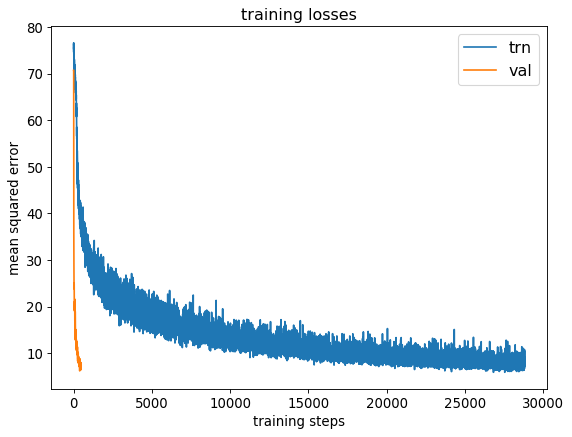

In [29]:
plt.plot(trn_losses)
plt.plot(val_losses)
plt.title("training losses")
plt.xlabel("training steps")
plt.ylabel("mean squared error")
plt.legend(["trn", "val"])
plt.show()

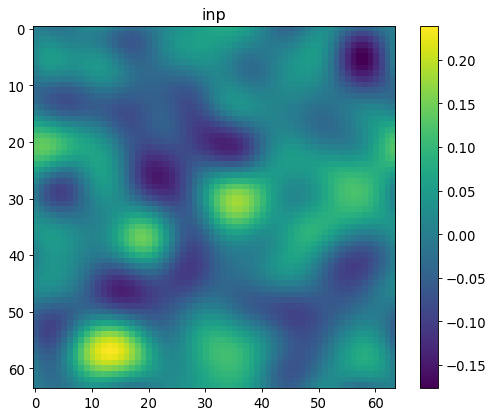

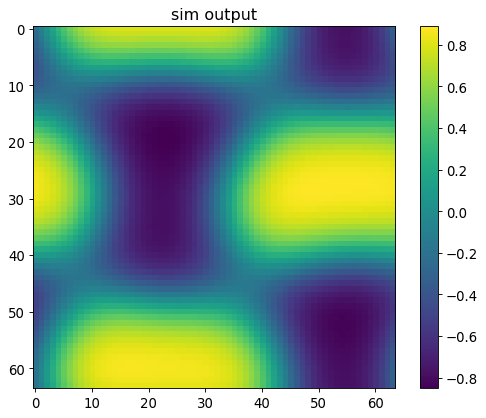

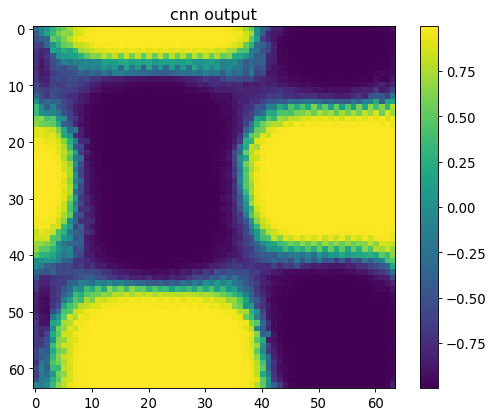

tensor(0.1972, device='cuda:0', dtype=torch.float64)


In [81]:
ix = 12

item_prd = val_dataset[ix]
x1 = item_prd['x'].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(y1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

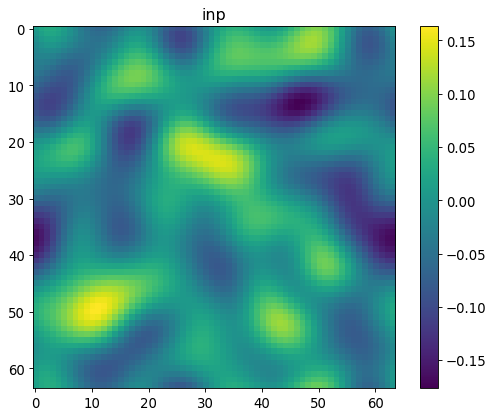

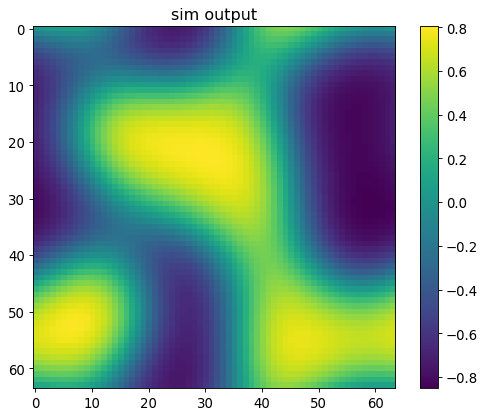

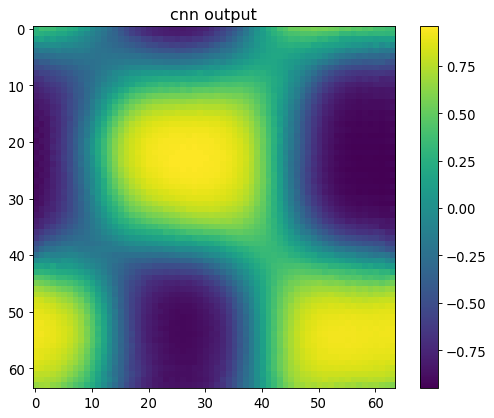

tensor(0.0669, device='cuda:0', dtype=torch.float64)


In [50]:
ix = 12

item_prd = prd_dataset[ix]
x1 = item_prd['x'].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(y1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

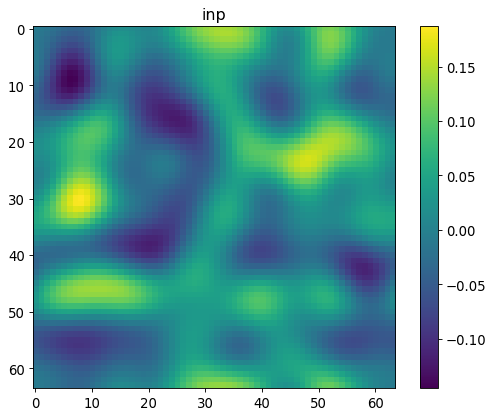

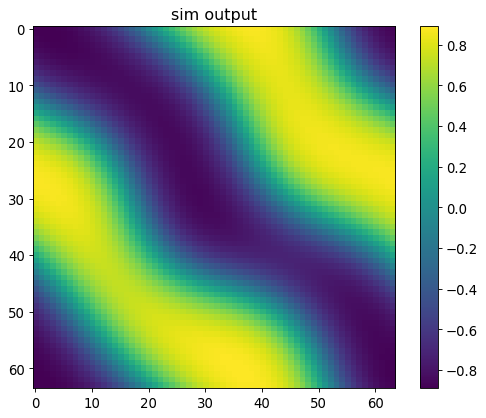

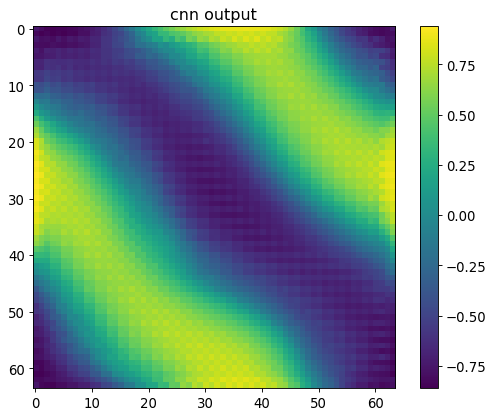

tensor(0.0289, device='cuda:0', dtype=torch.float64)


In [43]:
ix = 3

item_prd = prd_dataset[ix]
x1 = item_prd['x'].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(y1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

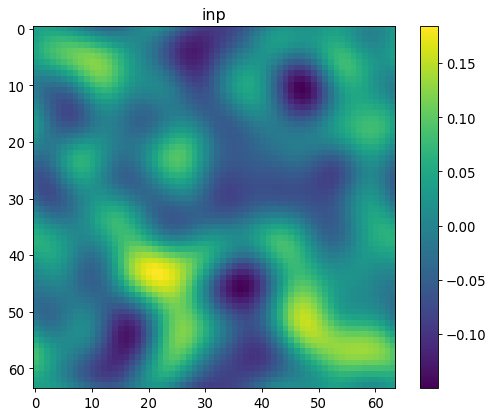

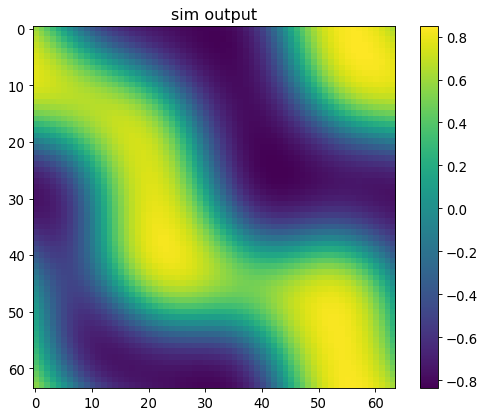

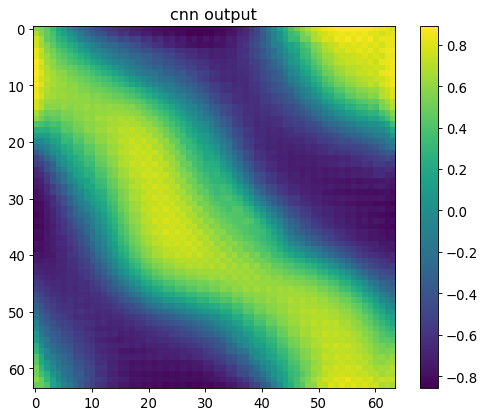

tensor(0.0435, device='cuda:0', dtype=torch.float64)


In [44]:
ix = 15

item_prd = prd_dataset[ix]
x1 = item_prd['x'].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(y1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)